In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

import digger
from trace_process import *

In [8]:
TIME_DELTA = 5000 * NANO_TO_MICRO

In [9]:
IPS = [237, 212, 144]
MASTER = 237
TARGET_IP = 229

SHIFT_WINDOW = 5
TARGET_COLUMN = 'size'
NUMBER_OF_TREES = 50

PACKETS = "../data/24/node-1/train/packets"
ALLOCS = "../data/24/node-1/train/allocations"
DISK_READS = "../data/24/node-1/train/disk_read"
DISK_WRITES = "../data/24/node-1/train/disk_write"
VIRTUAL_MEMORY = "../data/24/node-1/train/memory"
RSS_MEMORY = "../data/24/node-1/train/rss_memory"
DATA_MEMORY = "../data/24/node-1/train/data_memory"
ALLOCATIONS = "../data/24/node-1/train/allocations"
S_TIME = "../data/24/node-1/train/s_time"
U_TIME = "../data/24/node-1/train/u_time"

# Filter Packet Trace to Master and Target

In [10]:
packets_df = get_trace(PACKETS, names=['timestamp', 'size', 'src_ip', 'dest_ip', 'src_port', 'dest_port', 'dir'], dtype={'dir': 'int8'})
packets_df = packets_df[packets_df['src_ip'].isin([MASTER, TARGET_IP]) & packets_df['dest_ip'].isin([MASTER, TARGET_IP])]

# Split to Packets of Flows

# Flow Extraction for IP

In [11]:
flows_packets_df = extract_flow_by_ip(packets_df, TARGET_IP, MASTER)

In [12]:
flows_times, flows_sizes = [], []
for idx in range(len(flows_packets_df)):
    flow_time, flow_size = get_flow(flows_packets_df[idx].values, TIME_DELTA)
    flows_times.append(flow_time)
    flows_sizes.append(flow_size)

# Flowgaps

In [13]:
flows_gaps = []
for ft in flows_times:
    flow_gap = np.roll(np.roll(ft[:, 0], -1) - ft[:, 1], 1)
    flows_gaps.append(flow_gap)

# Network In/Out

In [14]:
flows_networkins = []
flows_networkouts = []
for idx in range(len(flows_times)):
    fts = flows_times[idx][:, 0]
    src_ip, dest_ip = flows_packets_df[idx][['src_ip', 'dest_ip']].values[0]
    in_data = packets_df[(packets_df['src_ip'] == src_ip) & (packets_df['dest_ip'] == dest_ip)][['timestamp', 'size']].values
    out_data = packets_df[(packets_df['src_ip'] == dest_ip) & (packets_df['dest_ip'] == src_ip)][['timestamp', 'size']].values
    in_data[:, 1] = np.cumsum(in_data[:, 1])
    out_data[:, 1] = np.cumsum(out_data[:, 1])
    flows_networkins.append(in_data[np.searchsorted(in_data[:, 0], fts), 1])
    flows_networkouts.append(out_data[np.searchsorted(out_data[:, 0], fts), 1])

# Other Traces

In [15]:
trace_names = [ALLOCS, DISK_READS, DISK_WRITES, VIRTUAL_MEMORY, RSS_MEMORY, DATA_MEMORY, S_TIME, U_TIME]
non_cum = [ALLOCS]
agg_record_results = {}
for trace_name in trace_names:
    print(trace_name)
    sep = ','
    if trace_name == ALLOCATIONS:
        sep = '\t'
    _df = get_trace(trace_name, sep=sep, names=['timestamp', 'size'], dtype={})
    agg_record_results[trace_name] = []
    for idx in range(len(flows_times)):
        fts = flows_times[idx][:, 0]
        
        values_in_df = np.searchsorted(_df['timestamp'].values, fts)
        values_in_df[values_in_df == len(_df)] = len(_df) - 1
        
        if trace_name in non_cum:
            size_csum = np.cumsum(_df['size'])
            aggregated_record_in_flow = size_csum[values_in_df].values
        else:
            aggregated_record_in_flow = _df['size'][values_in_df].values
            
        agg_record_results[trace_name].append(aggregated_record_in_flow)

../data/24/node-1/train/allocations
../data/24/node-1/train/disk_read
../data/24/node-1/train/disk_write
../data/24/node-1/train/memory
../data/24/node-1/train/rss_memory
../data/24/node-1/train/data_memory
../data/24/node-1/train/s_time
../data/24/node-1/train/u_time


In [16]:
_df = get_trace(ALLOCATIONS, sep='\t', names=['timestamp', 'size'], dtype={})

In [17]:
_df['timestamp'].values.min() > packets_df['timestamp'].values

array([False, False, False, ..., False, False, False])

In [18]:
values_in_df[100:150]

array([ 8623,  8699,  8792,  8817,  8841,  8922,  9009,  9030,  9051,
        9136,  9222,  9244,  9264,  9346,  9443,  9465,  9488,  9567,
        9661,  9677,  9699,  9777,  9867,  9890,  9915,  9995, 10089,
       10102, 10131, 10210, 10300, 10324, 10345, 10422, 10430, 10527,
       10536, 10544, 10558, 10656, 10750, 10773, 10791, 10889, 10978,
       11004, 11026, 11101, 11185, 11194])

# Create DS

In [19]:
datasets = []
for idx in range(len(flows_gaps)):
    ds = pd.DataFrame({'start_time': flows_times[idx][:, 0], 'size': flows_sizes[idx], 'gap': flows_gaps[idx], 'networkin': flows_networkins[idx], 'networkout': flows_networkouts[idx]})[1:]
    for trace_name in agg_record_results:
        t_name = trace_name.split('/')[-1]
        trace_ds = pd.DataFrame({t_name: agg_record_results[trace_name][idx]})
        ds = pd.concat([ds, trace_ds], axis=1)
    datasets.append(ds)

## Shifting

In [20]:
for idx in range(len(datasets)):
    main_ds = datasets[idx]
    for s in range(1, SHIFT_WINDOW):
        shifted_ds = main_ds.shift(s).fillna(0)
        shifted_ds.columns = map(lambda x: x + str(s), shifted_ds.columns)
        datasets[idx] = pd.concat([shifted_ds, main_ds], axis=1)

## Catching Labels / Target Value

In [21]:
outputs = []
feature_names = []
for idx in range(len(datasets)):
    outputs.append(datasets[idx][TARGET_COLUMN].fillna(0).values)
    datasets[idx] = datasets[idx].fillna(0).drop(TARGET_COLUMN, axis=1)
    feature_names.append(datasets[idx].columns)

## Scaling

In [16]:
for idx in range(len(datasets)):
    outputs[idx] = MinMaxScaler().fit_transform(outputs[idx].reshape(-1, 1))[:, 0]
    datasets[idx] = MinMaxScaler().fit_transform(datasets[idx])

# Model

In [17]:
param = {
    'max_depth' : 10,
    'objective' : 'reg:squarederror',
    'booster' : 'gbtree',
    'base_score' : 2,
    'eval_metric': 'mae',
    'predictor': 'gpu_predictor',
    'tree_method': 'gpu_hist'
}
train_mat = xgb.DMatrix(datasets[0], outputs[0], feature_names=feature_names[0])

In [18]:
model = xgb.train(param, train_mat, NUMBER_OF_TREES)

In [19]:
pred = model.predict(train_mat)

In [20]:
mse = mean_squared_error(outputs[0], pred)
mae = mean_absolute_error(outputs[0], pred)
r2 = r2_score(outputs[0], pred)
print('MSE: %f' % mse)
print('MAE: %f' % mae)
print('R2: %f' % r2)

MSE: 0.001881
MAE: 0.018477
R2: 0.972422


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

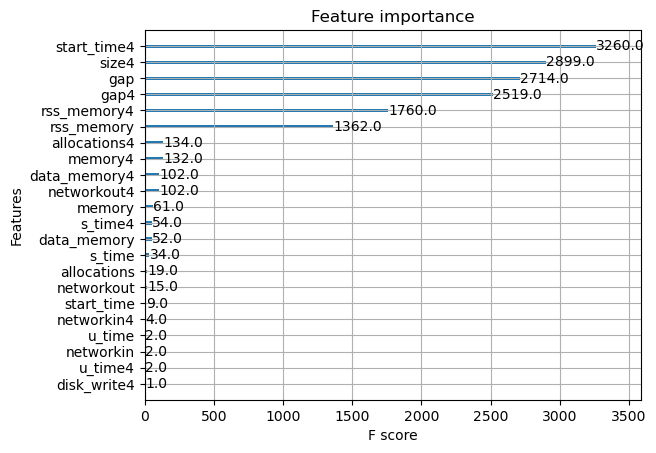

In [21]:
xgb_fea_imp = pd.DataFrame(list(model.get_fscore().items()), columns=['feature','importance']).sort_values('importance', ascending=False)
plot_importance(model, )

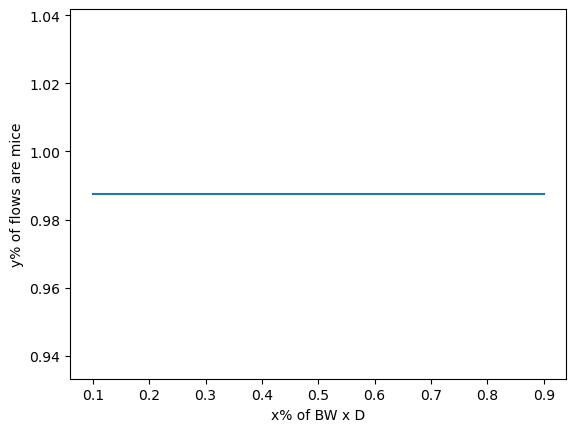

In [51]:
WHOLE = 34552 # Bytes
xs = np.arange(0.1, 1, 0.1)
ys = []
for x in xs:
    ys.append(np.sum((flows_sizes[0] < 8000000) * 1) / len(flows_sizes[0]))
plt.xlabel("x% of BW x D")
plt.ylabel("y% of flows are mice")
# plt.yticks(np.concatenate([np.arange(-10, 0), np.arange(0, 100, 10)]))
plt.plot(xs, ys)

In [41]:
ys

[0.5160375951066687,
 0.5160375951066687,
 0.5160375951066687,
 0.5160375951066687,
 0.5160375951066687,
 0.5160375951066687,
 0.5160375951066687,
 0.5160375951066687,
 0.5160375951066687]

# Fast Mode

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

import digger
from trace_process import *

nsdi_features = [digger.DISK_READS, digger.DISK_WRITES, digger.VIRTUAL_MEMORY, digger.S_TIME]
all_features = [digger.ALLOCS, digger.DISK_READS, digger.DISK_WRITES, digger.VIRTUAL_MEMORY, digger.RSS_MEMORY, digger.DATA_MEMORY, digger.S_TIME, digger.U_TIME]

# Flux Features

In [ ]:
deltas, test_scores, train_scores = digger.run_flux_regression([digger.TENSORFLOW_PREFIX2], files=nsdi_features)
plt.xlabel("Timedelta (Microseconds)")
plt.ylabel("R2 Score")
# plt.yticks(np.concatenate([np.arange(-10, 0), np.arange(0, 100, 10)]))
plt.plot(deltas, [s[2] for s in test_scores])
plt.plot(deltas, [s[2] for s in train_scores])

INFO:root:Creating train dataset for 500000


In [2]:
deltas, test_scores, train_scores = digger.run_flux_regression([digger.SPARK_PREFIX7], files=all_features)
plt.xlabel("Timedelta (Microseconds)")
plt.ylabel("R2 Score")
# plt.yticks(np.concatenate([np.arange(-10, 0), np.arange(0, 100, 10)]))
plt.plot(deltas, [s[2] for s in test_scores])
plt.plot(deltas, [s[2] for s in train_scores])

NameError: name 'digger' is not defined

# Classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

import digger
from trace_process import *

nsdi_features = [digger.DISK_READS, digger.DISK_WRITES, digger.VIRTUAL_MEMORY, digger.S_TIME]
all_features = [digger.ALLOCS, digger.DISK_READS, digger.DISK_WRITES, digger.VIRTUAL_MEMORY, digger.RSS_MEMORY, digger.DATA_MEMORY, digger.S_TIME, digger.U_TIME]

In [ ]:
deltas, test_scores_nsdi, train_scores_nsdi = digger.run_flux_regression([digger.SPARK_PREFIX9], files=nsdi_features, output_type=digger.CLASSIFICATION)

In [ ]:
deltas, test_scores_full, train_scores_full = digger.run_flux_regression([digger.SPARK_PREFIX10], files=all_features, output_type=digger.CLASSIFICATION)

In [ ]:
plt.xlabel("Flowlet time threshold (Microseconds)")
plt.ylabel("F1")
plt.plot(deltas, [s[-1] for s in test_scores_full], '-b', label='Full features test score')
#plt.plot(deltas, [s[-1] for s in train_scores_nsdi])
plt.plot(deltas, [s[-1] for s in train_scores_full], '--b', label='Full features train score')
plt.plot(deltas, [s[-1] for s in test_scores_nsdi], '-r', label='NSDI features test score')
#plt.plot(deltas, [s[-1] for s in train_scores_nsdi])
plt.plot(deltas, [s[-1] for s in train_scores_nsdi], '--r', label='NSDI features train score')
plt.legend(loc="best")

#plt.plot(deltas, [s[-1] for s in train_scores_full])

# Data transmition in larger timeslots

In [2]:
secs = 1

In [3]:
packets_df = get_trace(PACKETS, names=['timestamp', 'size', 'src_ip', 'dest_ip', 'src_port', 'dest_port', 'dir'], dtype={'dir': 'int8'})
# packets_df = packets_df[packets_df['src_ip'].isin([MASTER, TARGET_IP]) & packets_df['dest_ip'].isin([MASTER, TARGET_IP])]

# Get Timeslots

In [6]:
start_time = packets_df['timestamp'].values[0]
end_time = packets_df['timestamp'].values[-1]
time_slots = np.arange(start_time, end_time, NANO_TO_SECONDS * secs)
time_slots = np.column_stack([time_slots, np.roll(time_slots, -1)])[:-2]

In [14]:
# Create paths
prefix = digger.TENSORFLOW_PREFIX
TRAIN = 'train'
TEST = 'test'
files=[digger.ALLOCS, digger.DISK_READS, digger.DISK_WRITES, digger.VIRTUAL_MEMORY, digger.RSS_MEMORY, digger.DATA_MEMORY, digger.S_TIME, digger.U_TIME]
train_paths = []
test_paths = []
for f in files:
    train_paths.append(f"{prefix}/{TRAIN}/{f}")
    test_paths.append(f"{prefix}/{TEST}/{f}")
packets_train = f"{prefix}/{TRAIN}/{PACKETS}"
packets_test = f"{prefix}/{TEST}/{PACKETS}"

# Get data

In [28]:
src_ip, dest_ip = TARGET_IP, MASTER
in_data = packets_df[(packets_df['src_ip'] == src_ip) & (packets_df['dest_ip'] == dest_ip)][['timestamp', 'size']].values
out_data = packets_df[(packets_df['src_ip'] == dest_ip) & (packets_df['dest_ip'] == src_ip)][['timestamp', 'size']].values
in_data[:, 1] = np.cumsum(in_data[:, 1])
out_data[:, 1] = np.cumsum(out_data[:, 1])
ins = in_data[np.searchsorted(in_data[:, 0], time_slots, side='left'), 1]
ins = ins[:, 1] - ins[:, 0]
outs = out_data[np.searchsorted(out_data[:, 0], time_slots, side='left'), 1]
outs = outs[:, 1] - outs[:, 0]

In [29]:
ds = pd.DataFrame({'network_out': outs, 'network_in': ins, 'time': time_slots[:, 0]})

In [30]:
trace_names=[ALLOCS, DISK_READS, DISK_WRITES, VIRTUAL_MEMORY, RSS_MEMORY, DATA_MEMORY, S_TIME, U_TIME]
CUM_TRACES = [ALLOCS]

agg_record_results = {}
for trace_name in trace_names:
    print(trace_name)
    sep = ','
    if trace_name == ALLOCATIONS:
        sep = '\t'
    fts = time_slots[:, 0]
    _df = get_trace(trace_name, sep=sep, names=['timestamp', 'size'], dtype={})
    values_in_df = np.searchsorted(_df['timestamp'].values, fts)
    values_in_df[values_in_df == len(_df)] = len(_df) - 1

    if (any([c in trace_name for c in CUM_TRACES])):
        size_csum = np.cumsum(_df['size'])
        aggregated_record_in_flow = size_csum[values_in_df].values
    else:
        aggregated_record_in_flow = _df['size'][values_in_df].values
    
    agg_record_results[trace_name] = aggregated_record_in_flow

../data/23/node-2/test/allocations
../data/23/node-2/test/disk_read
../data/23/node-2/test/disk_write
../data/23/node-2/test/memory
../data/23/node-2/test/rss_memory
../data/23/node-2/test/data_memory
../data/23/node-2/test/s_time
../data/23/node-2/test/u_time


In [31]:
for trace_name in agg_record_results:
    t_name = trace_name.split('/')[-1]
    trace_ds = pd.DataFrame({t_name: agg_record_results[trace_name]})
    ds = pd.concat([ds, trace_ds], axis=1)

In [32]:
main_ds = ds.copy()
SHIFT_WINDOW = 10
for s in range(1, SHIFT_WINDOW):
    shifted_ds = main_ds.shift(s).fillna(0)
    shifted_ds.columns = map(lambda x: x + str(s), shifted_ds.columns)
    ds = pd.concat([shifted_ds, ds], axis=1)

In [33]:
target_column = 'network_out'
output = ds[target_column].fillna(0).values
ds = ds.fillna(0).drop(target_column, axis=1)
feature_names = ds.columns
output = MinMaxScaler().fit_transform(output.reshape(-1, 1))[:, 0]
ds = MinMaxScaler().fit_transform(ds)

In [22]:
param = {
    'max_depth' : 5,
    'objective' : 'reg:squarederror',
    'booster' : 'gbtree',
    'base_score' : 2,
    'eval_metric': 'mae',
    'predictor': 'gpu_predictor',
    'tree_method': 'gpu_hist'
}
train_mat = xgb.DMatrix(ds, output, feature_names=feature_names)
model = xgb.train(param, train_mat, NUMBER_OF_TREES)
pred = model.predict(train_mat)
mse = mean_squared_error(output, pred)
mae = mean_absolute_error(output, pred)
r2 = r2_score(output, pred)
print('MSE: %f' % mse)
print('MAE: %f' % mae)
print('R2: %f' % r2)

MSE: 0.000001
MAE: 0.000282
R2: 0.999995


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

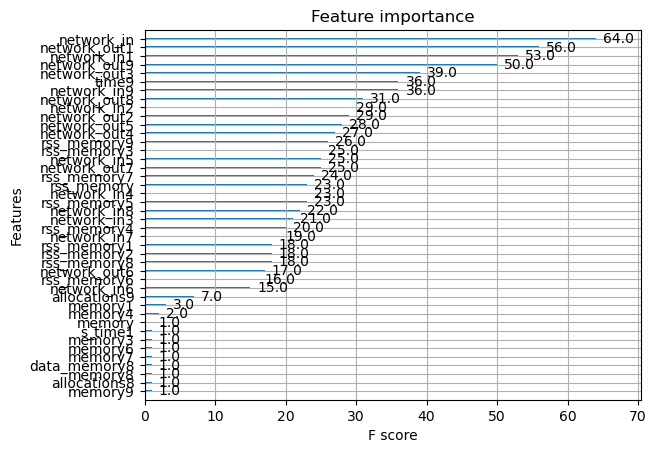

In [23]:
xgb_fea_imp = pd.DataFrame(list(model.get_fscore().items()), columns=['feature','importance']).sort_values('importance', ascending=False)
plot_importance(model, )

In [34]:
PACKETS = "../data/23/node-2/test/packets"
ALLOCS = "../data/23/node-2/test/allocations"
DISK_READS = "../data/23/node-2/test/disk_read"
DISK_WRITES = "../data/23/node-2/test/disk_write"
VIRTUAL_MEMORY = "../data/23/node-2/test/memory"
RSS_MEMORY = "../data/23/node-2/test/rss_memory"
DATA_MEMORY = "../data/23/node-2/test/data_memory"
ALLOCATIONS = "../data/23/node-2/test/allocations"
S_TIME = "../data/23/node-2/test/s_time"
U_TIME = "../data/23/node-2/test/u_time"

In [35]:
test_mat = xgb.DMatrix(ds, output, feature_names=feature_names)
pred = model.predict(test_mat)
mse = mean_squared_error(output, pred)
mae = mean_absolute_error(output, pred)
r2 = r2_score(output, pred)
print('MSE: %f' % mse)
print('MAE: %f' % mae)
print('R2: %f' % r2)

MSE: 0.001353
MAE: 0.003021
R2: -2.751493


# Fast Mode

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

import digger
from trace_process import *

TIME_DELTA = 5000 * NANO_TO_MICRO

IPS = [237, 212, 144]
MASTER = 237
TARGET_IP = 229

SHIFT_WINDOW = 5
TARGET_COLUMN = 'size'
NUMBER_OF_TREES = 50

PACKETS = "../data/24/node-1/train/packets"
ALLOCS = "../data/24/node-1/train/allocations"
DISK_READS = "../data/24/node-1/train/disk_read"
DISK_WRITES = "../data/24/node-1/train/disk_write"
VIRTUAL_MEMORY = "../data/24/node-1/train/memory"
RSS_MEMORY = "../data/24/node-1/train/rss_memory"
DATA_MEMORY = "../data/24/node-1/train/data_memory"
ALLOCATIONS = "../data/24/node-1/train/allocations"
S_TIME = "../data/24/node-1/train/s_time"
U_TIME = "../data/24/node-1/train/u_time"

INFO:root:Creating train dataset for 1000000000.0
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Creating train dataset for 2000000000.0
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Creating train dataset for 3000000000.0
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Creating train dataset for 4000000000.0
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Creating train dataset for 5000000000.0
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Creating train dataset for 6000000000.0
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Creating train dataset for 7000000000.0
INFO:root:Extr

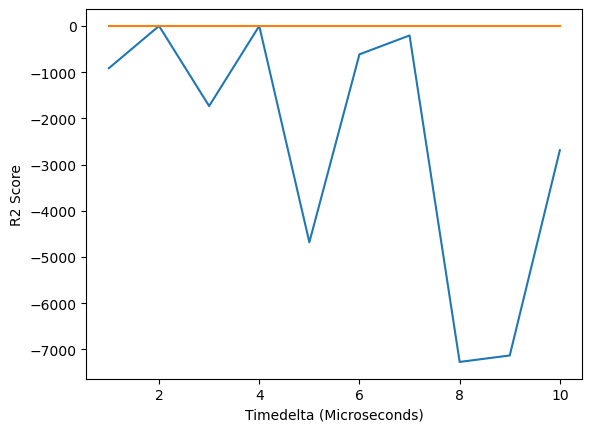

In [2]:
deltas, test_scores, train_scores = digger.run_longer_time_slot(digger.TENSORFLOW_PREFIX, files=[digger.ALLOCS, digger.DISK_READS, digger.DISK_WRITES, digger.VIRTUAL_MEMORY, digger.RSS_MEMORY, digger.DATA_MEMORY, digger.S_TIME, digger.U_TIME])
plt.xlabel("Timedelta (Microseconds)")
plt.ylabel("R2 Score")
# plt.yticks(np.concatenate([np.arange(-10, 0), np.arange(0, 100, 10)]))
plt.plot(deltas, [s[-1] for s in test_scores])
plt.plot(deltas, [s[-1] for s in train_scores])

INFO:root:Creating train dataset for 1000000000.0
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Creating train dataset for 2000000000.0
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Creating train dataset for 3000000000.0
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Creating train dataset for 4000000000.0
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Creating train dataset for 5000000000.0
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Creating train dataset for 6000000000.0
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Creating train dataset for 7000000000.0
INFO:root:Extr

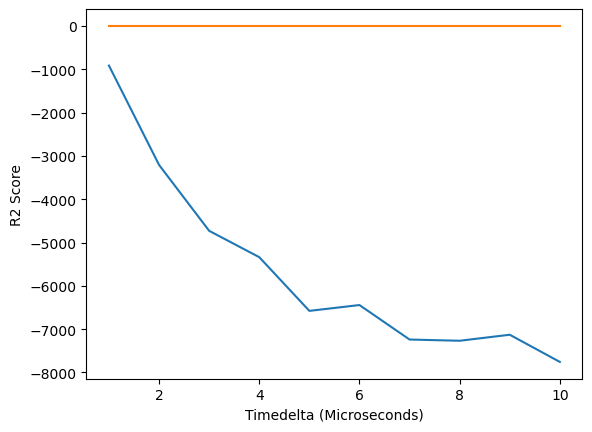

In [6]:
deltas, test_scores, train_scores = digger.run_longer_time_slot(digger.TENSORFLOW_PREFIX, files=[digger.DISK_READS, digger.DISK_WRITES, digger.RSS_MEMORY, digger.S_TIME, digger.U_TIME])
plt.xlabel("Timedelta (Microseconds)")
plt.ylabel("R2 Score")
# plt.yticks(np.concatenate([np.arange(-10, 0), np.arange(0, 100, 10)]))
plt.plot(deltas, [s[-1] for s in test_scores])
plt.plot(deltas, [s[-1] for s in train_scores])

INFO:root:Creating train dataset for 1000000000.0
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Creating train dataset for 2000000000.0
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Creating train dataset for 3000000000.0
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Creating train dataset for 4000000000.0
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Creating train dataset for 5000000000.0
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Creating train dataset for 6000000000.0
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Creating train dataset for 7000000000.0
INFO:root:Extr

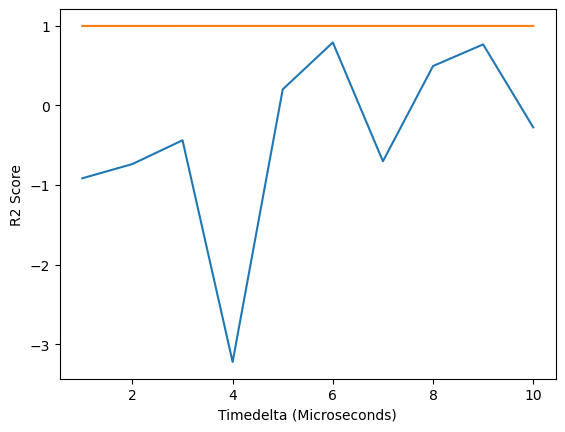

In [7]:
deltas, test_scores, train_scores = digger.run_longer_time_slot(digger.SPARK_PREFIX, files=[digger.ALLOCS, digger.DISK_READS, digger.DISK_WRITES, digger.VIRTUAL_MEMORY, digger.RSS_MEMORY, digger.DATA_MEMORY, digger.S_TIME, digger.U_TIME])
plt.xlabel("Timedelta (Microseconds)")
plt.ylabel("R2 Score")
# plt.yticks(np.concatenate([np.arange(-10, 0), np.arange(0, 100, 10)]))
plt.plot(deltas, [s[-1] for s in test_scores])
plt.plot(deltas, [s[-1] for s in train_scores])

INFO:root:Creating train dataset for 1000000000.0
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Creating train dataset for 2000000000.0
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Creating train dataset for 3000000000.0
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Creating train dataset for 4000000000.0
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Creating train dataset for 5000000000.0
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Creating train dataset for 6000000000.0
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Extracting flow
INFO:root:Shaping features
INFO:root:Creating train dataset for 7000000000.0
INFO:root:Extr

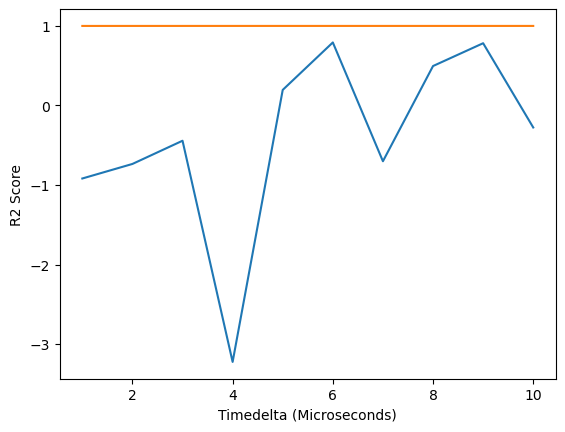

In [8]:
deltas, test_scores, train_scores = digger.run_longer_time_slot(digger.SPARK_PREFIX, files=[digger.DISK_READS, digger.DISK_WRITES, digger.RSS_MEMORY, digger.S_TIME, digger.U_TIME])
plt.xlabel("Timedelta (Microseconds)")
plt.ylabel("R2 Score")
# plt.yticks(np.concatenate([np.arange(-10, 0), np.arange(0, 100, 10)]))
plt.plot(deltas, [s[-1] for s in test_scores])
plt.plot(deltas, [s[-1] for s in train_scores])

# Diagrams

In [3]:
import matplotlib.pyplot as plt

In [4]:
full_features_results = [{'train': (0.0009141238573451525, 0.9990807261490923, 0.999995444200676, 0.9866317169069462), 'test': (0.00358093452777929, 0.99531354206096, 0.982199686412184, 0.9374498797113072)}, {'train': (0.02527788277243883, 0.9747154273022541, 0.9993773976853206, 0.4561479243111015), 'test': (0.007539512195121948, 0.9753678048780487, 0.7859581434559985, 0.254957507082153)}, {'train': (0.03732570030487514, 0.9623206827673869, 0.9971037648292854, 0.5191193511008111), 'test': (0.00894230983654079, 0.9730838703922574, 0.7227702184074045, 0.3153715258082813)}, {'train': (0.0733633394537153, 0.9253475889486483, 0.9900858176946257, 0.5005254575104187), 'test': (0.0279045079429272, 0.9201284011778533, 0.8270532598717124, 0.32708688245315165)}, {'train': (0.0818945829907737, 0.914531378459852, 0.9832832076022782, 0.5628431258030604), 'test': (0.032717874936722374, 0.9051767777688967, 0.8398775899206944, 0.4034528997653369)}, {'train': (0.07717573709009906, 0.9159326123177803, 0.9804432400565214, 0.6313473877176902), 'test': (0.046248171114052786, 0.8931373232076918, 0.8610464983982677, 0.49134443191616367)}, {'train': (0.07064516928567888, 0.9186350567590343, 0.9777272258783549, 0.6798644464490333), 'test': (0.04529747704763973, 0.8909419504084436, 0.8589390030703312, 0.545903317079044)}, {'train': (0.06401883207850106, 0.9240831835424009, 0.9797451099125297, 0.7241154865405178), 'test': (0.049120136121434635, 0.8953267959223272, 0.879165951829203, 0.6112743196053433)}, {'train': (0.058688215170461216, 0.9259630634527414, 0.9798319289981033, 0.7431040363843092), 'test': (0.0407223904333731, 0.9006483775269902, 0.8739995765384448, 0.6434334010208002)}, {'train': (0.05454910087572702, 0.9281903870579584, 0.9804964366197743, 0.7594931040659144), 'test': (0.043003540734039364, 0.8984105691690973, 0.8785224909580172, 0.6534347895493003)}, {'train': (0.0500448894088201, 0.9285034143156405, 0.9792803295433058, 0.7664207625988801), 'test': (0.04016695232654098, 0.9004475338030852, 0.8776654580305394, 0.6692676754362841)}, {'train': (0.0481569190618549, 0.9286172923038685, 0.9776113186559995, 0.7729438893159108), 'test': (0.035408779701973425, 0.9019250906161901, 0.8763059926445775, 0.6787674124102997)}, {'train': (0.04450065514269497, 0.9308491630289314, 0.9789703648575078, 0.7840339628421997), 'test': (0.02802256192266818, 0.8998119839777651, 0.8728827606234293, 0.6742158426368952)}, {'train': (0.04216721875488705, 0.9317164019960477, 0.978644313744615, 0.7912193001521409), 'test': (0.02401685160305847, 0.9008807284669353, 0.871438169986029, 0.6819584885577435)}, {'train': (0.03936167912411073, 0.9334938265375994, 0.9799383597523211, 0.8003116410933407), 'test': (0.021140262361251244, 0.9005886310124454, 0.8726134025759554, 0.6865687470173393)}, {'train': (0.03806835631864515, 0.9342030214838323, 0.9800268334044674, 0.8067937816713906), 'test': (0.016396799126414008, 0.9001006671330342, 0.8648514980774474, 0.688845193176383)}, {'train': (0.03350161985039554, 0.9334341569735115, 0.9787460805314281, 0.8071396352857787), 'test': (0.018266735858847957, 0.9007438159487978, 0.8671652713354168, 0.6991085474567383)}, {'train': (0.03117471800914076, 0.9356543013456011, 0.9794231573103276, 0.8164025695931476), 'test': (0.021923373257687145, 0.8996637949148981, 0.8668938897447336, 0.705004118616145)}, {'train': (0.02939501833392806, 0.933026123000539, 0.977500964165396, 0.8117290537368219), 'test': (0.017040422290714563, 0.9021504233535268, 0.8627091716105657, 0.7139306059036767)}]
nsdi_features_results = [{'train': (0.0008806488991888461, 0.9991090511136861, 0.9999937642256511, 0.9870373145511764), 'test': (0.002535493910608814, 0.9952774923845058, 0.9857201507112748, 0.9378361278076558)}, {'train': (0.025849871386185927, 0.9741434386885071, 0.9993594103442762, 0.45060412224591334), 'test': (0.005393170731707314, 0.978200975609756, 0.8033096547260629, 0.29487503155768746)}, {'train': (0.042137757686389596, 0.9573461527433984, 0.9961790749691883, 0.4871293955412549), 'test': (0.007927658720424575, 0.9724483196931517, 0.7518120424203034, 0.31683715786563454)}, {'train': (0.07835713782775187, 0.9196930059741427, 0.9875063616678185, 0.4800645229161553), 'test': (0.02835947274634446, 0.921417468120869, 0.8309427770839725, 0.34047518031395846)}, {'train': (0.0840983831186626, 0.9117566456563442, 0.981270815463986, 0.5536817788045048), 'test': (0.03789998134974557, 0.903937868009485, 0.8540461680512981, 0.41473906338771205)}, {'train': (0.07880011227299061, 0.9147023869954434, 0.9794851796626254, 0.628598174584601), 'test': (0.0424022852365359, 0.8969274716087229, 0.8675353876974727, 0.5002364705087494)}, {'train': (0.07163659346651464, 0.9201098002280276, 0.9808003057979234, 0.6868883114359959), 'test': (0.0359141184124919, 0.8952649461432806, 0.8674514364434706, 0.5461721588773337)}, {'train': (0.06451138304473258, 0.9228741948071055, 0.97871799642249, 0.7202227636616777), 'test': (0.04247824594396932, 0.8955805310527023, 0.8733975159587652, 0.6024096385542168)}, {'train': (0.05939601274035623, 0.9256878088422267, 0.979299558271394, 0.7427806637479301), 'test': (0.04122702388598343, 0.8991956448603847, 0.8799783164211437, 0.6388736715240495)}, {'train': (0.0567484457517214, 0.9264456180225951, 0.978799684600894, 0.7554508479096749), 'test': (0.03713871254542901, 0.8974434964358691, 0.8764790023705287, 0.6429928870065701)}, {'train': (0.05120793318279512, 0.9286462442527954, 0.9796065236483873, 0.7677697841726617), 'test': (0.03729448359042721, 0.8993207642988638, 0.877001191027012, 0.662301714042372)}, {'train': (0.04845380042668067, 0.9288865567975476, 0.9795421429310035, 0.7740137785773838), 'test': (0.03705195328231979, 0.9021184051550544, 0.8784167476261033, 0.6811168258633358)}, {'train': (0.045404541855560296, 0.9301134412859015, 0.9781883650998331, 0.782350630646358), 'test': (0.024932559470285276, 0.8979318237554157, 0.8704592370027536, 0.6647333655550184)}, {'train': (0.04188998990602648, 0.9307994142652014, 0.9775187381613454, 0.7882360618650889), 'test': (0.025609129057404895, 0.8998192101640378, 0.8725669442571355, 0.6801863814465742)}, {'train': (0.03932564023093722, 0.9313242851685539, 0.9770561356288578, 0.7937751612484308), 'test': (0.01664984863773966, 0.8969054826774302, 0.8657207077865195, 0.6702882960413081)}, {'train': (0.03746873948842451, 0.9330622870263393, 0.9782612282926345, 0.8030974403097442), 'test': (0.015987305703902138, 0.900783156170554, 0.8691541957040758, 0.6905762784015325)}, {'train': (0.033775919459703915, 0.9330115873051176, 0.9772544556522529, 0.806069451002275), 'test': (0.01970247362048086, 0.9017298045320878, 0.8708522201360684, 0.703388503106563)}, {'train': (0.03129479395717792, 0.9331627254238306, 0.9771731070421874, 0.8093586779690043), 'test': (0.03356797646564402, 0.8827309658891924, 0.8605432322442499, 0.6666334810095077)}, {'train': (0.027542646310818916, 0.9322214040068932, 0.97495644694034, 0.8084695585017375), 'test': (0.014808516668437993, 0.9032132355546109, 0.8684776152313036, 0.7151793160967473)}]

full_features_r_results = [{'train': (0.001526973091283662, 0.9950740311574611, 0.9515682283119238, 0.9257289280583919, 1.2874983906270117e-06, 4.32626909890766e-05, 0.0009169921255004427, 0.9713852680759113), 'test': (0.0014119456611210203, 0.9930844704002115, 0.945529470406873, 0.9102953783804847, 3.0041397045128185e-06, 0.0004901929660129538, 0.003236363806596949, 0.7318577937469608)}, {'train': (0.0060410025522065125, 0.9896908251019377, 0.6135541255937499, 0.3205467372134039, 0.0, 7.584532586901322e-08, 3.656098997761539e-05, 0.9998544354821463), 'test': (0.0043551219512194825, 0.9854985365853659, 0.6280116666823816, 0.31489675516224186, 3.9024390243902435e-06, 0.00020562886299971823, 0.0005934761971655112, 0.6344830172756557)}, {'train': (0.01265375168445897, 0.9794615465484121, 0.5934918491631054, 0.27618726844055236, 0.0, 4.292109779788606e-08, 4.989218734326365e-05, 0.9999448057052858), 'test': (0.009209910130901128, 0.9533929487322436, 0.5982238434605784, 0.18897943344974777, 0.0, 0.0003530782183721284, 0.0010510494264988316, 0.5796826377822861)}, {'train': (0.018821528578933953, 0.9596108953631336, 0.6053556875422237, 0.29484633569739954, 0.0, 6.569266348470866e-08, 6.031230546423742e-05, 0.9999278031433714), 'test': (0.012334601337091043, 0.9443679148710301, 0.6143568767734481, 0.29091494845360827, 6.318955603017933e-06, 0.0005942462157335936, 0.0017213870191078225, 0.3927908582174483)}, {'train': (0.029934000182698497, 0.9336747510733534, 0.5667361425473393, 0.20740942894180253, 0.0, 2.0471712050677016e-07, 9.079683927530338e-05, 0.999793338307304), 'test': (0.02840167319425576, 0.8700876561958809, 0.5556867071493117, 0.1598897312198484, 6.660805158127514e-06, 0.000697532973944957, 0.002120407760797625, 0.35610047123206123)}, {'train': (0.0825743957861797, 0.8828359679663659, 0.8313528345841189, 0.4980940929673309, 0.0, 1.1878351566220394e-07, 8.390292389564419e-05, 0.9998879112436081), 'test': (0.12922733923221624, 0.8283564411621264, 0.7886268238494096, 0.41432103461392156, 6.967184560719013e-06, 0.0006739661010630589, 0.0018716692122484708, 0.43371972472319476)}, {'train': (0.07271476726317352, 0.8891897585882119, 0.8456882985598111, 0.5675316195497085, 3.098200565111783e-06, 7.984245375100213e-08, 8.39851079173474e-05, 0.9999286990273385), 'test': (0.10460493023928286, 0.852801272319815, 0.820964208000073, 0.5084729396997055, 0.0, 0.0008128949989891464, 0.002162621406669909, 0.35703126993013223)}, {'train': (0.06396126118634417, 0.8928477761643713, 0.8498999774728703, 0.6105233788276871, 3.19838289760697e-06, 1.9085042880869722e-07, 9.509321433625552e-05, 0.9998364047252406), 'test': (0.06022477947432049, 0.8917148017134584, 0.8435091374875774, 0.6137875964865586, 0.0, 0.0006506298595226207, 0.0020553771117253023, 0.5082365083934004)}, {'train': (0.058773413026096746, 0.8952459596555385, 0.8536472603472388, 0.6366281713194506, 3.2768406013657873e-06, 1.0754119533163803e-07, 9.274656573663901e-05, 0.9999103287176779), 'test': (0.07509863290210114, 0.8733675872404196, 0.8344535530290883, 0.5954370022961551, 0.0, 0.0007292310910614841, 0.0020082585537225368, 0.4727128750306471)}, {'train': (0.05186844040377034, 0.8967243799719232, 0.8504929820957345, 0.6509725956216253, 0.0, 1.5064740470353402e-07, 9.136628547601908e-05, 0.999848190018571), 'test': (0.05501396016284256, 0.8739529877868073, 0.8062714736155774, 0.5869242958646425, 7.798973655066993e-06, 0.000997542368436843, 0.0042702089296424856, 0.06799486841655655)}, {'train': (0.047501156242348394, 0.8981826590853443, 0.8511226115539987, 0.6645753977145417, 3.4007127894006585e-06, 7.604306278365703e-08, 8.440556079162051e-05, 0.9999247936511977), 'test': (0.09601345775407856, 0.8400304703865931, 0.8038094369927665, 0.5517210708885528, 7.934996508601536e-06, 0.0009964473139816765, 0.003060286687118082, 0.08574111965412923)}, {'train': (0.04284067136613756, 0.9002133403296073, 0.8519177350919881, 0.6771361554786105, 3.452108893322931e-06, 9.095183993383327e-08, 8.55807976719996e-05, 0.9999113854763154), 'test': (0.0637132501006847, 0.8729762384212646, 0.8275914797914846, 0.6192476700951277, 0.0, 0.0012226244639411998, 0.0033675107437610113, -0.1026783788592851)}, {'train': (0.039771015366074094, 0.8991010180987549, 0.8483471100300451, 0.6801563679978676, 3.503436871571011e-06, 7.518022184130161e-08, 8.670554907721027e-05, 0.9999278225436651), 'test': (0.11290770865691165, 0.8257173219978746, 0.8067466169762154, 0.5558703441379885, 8.17460966238862e-06, 0.001087978046541828, 0.003970280394651548, 0.03586729773110309)}, {'train': (0.03471047356374127, 0.900816047996133, 0.8478118393607966, 0.6896643757923533, 3.5542160110322863e-06, 8.247166851580317e-08, 8.840461771806121e-05, 0.9999220193240349), 'test': (0.2513476306579755, 0.6970692143105937, 0.7484871112412681, 0.4379615952732644, 8.293111741387604e-06, 0.00079658167853603, 0.004937317001593053, 0.3067042628380948)}, {'train': (0.03181513489357714, 0.9000713570084835, 0.8454328611037158, 0.6930026572187776, 3.6038893173512853e-06, 7.939777338114486e-08, 9.129582724378553e-05, 0.9999259950766216), 'test': (0.0680961991254625, 0.8613689875546586, 0.820205316023213, 0.6192785552630362, 0.0, 0.0009183708241214634, 0.0032759225213381403, 0.21170334814930925)}, {'train': (0.027692060195679824, 0.9005001681852085, 0.8438393476255226, 0.6986468230239408, 0.0, 8.778962918731636e-08, 9.278635057554578e-05, 0.9999194520166873), 'test': (0.027197188145165446, 0.8464058421061612, 0.6660151781808801, 0.4464395523305867, 8.531112968997936e-06, 0.0008314715862974833, 0.0028297456563990296, 0.29648374894702567)}, {'train': (0.023686141938927582, 0.9010519760692125, 0.8429343744925308, 0.7049278181858378, 3.7067514771404638e-06, 8.012373654952136e-08, 9.26030245459234e-05, 0.9999274857446412), 'test': (0.06211728074727553, 0.8628437986507524, 0.820580883775141, 0.6330016199953714, 8.64902266043937e-06, 0.0008501654068652915, 0.0038796678331996506, 0.2904485284011019)}, {'train': (0.019519846302786498, 0.9005546007849965, 0.8394498357208865, 0.7064921257226394, 3.7523733761604215e-06, 8.999212080819395e-08, 9.66480410284552e-05, 0.9999195424599282), 'test': (0.04663094487637455, 0.8542235763815927, 0.7870079252233547, 0.6004319654427644, 8.755340757862296e-06, 0.0008045595554981408, 0.0033967667257052557, 0.3389346827652947)}, {'train': (0.015608511801279965, 0.9007766297457543, 0.8375829788886832, 0.7098263842635762, 0.0, 1.0629356132902281e-07, 9.703156229662553e-05, 0.9999060539789165), 'test': (0.0033124313600453453, 0.7801572962057605, 0.5920566177422621, 0.3166125213369308, 8.856768342367236e-06, 0.0009623555162292889, 0.0043980999497178755, 0.21831354661831748)}]
nsdi_features_r_results = [{'train': (0.00157074803656497, 0.9951435560705549, 0.9517873012834364, 0.9267288267288267, 1.2874983906270117e-06, 4.283496301596057e-05, 0.0009160006877689128, 0.9716681751491268), 'test': (0.0005407451468122729, 0.9925257004151721, 0.9471472695916646, 0.9041307028360049, 3.0041397045128185e-06, 0.0004734573930546003, 0.0032469570279951, 0.74101237932264)}, {'train': (0.006793619149242229, 0.9899350073756427, 0.6018223954914962, 0.30201809324982604, 0.0, 7.469243341123599e-08, 3.51362935842483e-05, 0.9998566481463128), 'test': (0.0038868292682926646, 0.9846243902439025, 0.6197206485240278, 0.2893217893217893, 3.9024390243902435e-06, 0.00020664467036662633, 0.0005956632578143908, 0.6326773619879449)}, {'train': (0.012462607399195264, 0.9795762331195703, 0.5971993318354353, 0.28504516560722654, 0.0, 7.234831110411854e-08, 5.276374441179271e-05, 0.9999069638427246), 'test': (0.01184131302544433, 0.9749793724773097, 0.6146920979065373, 0.3129210042865891, 0.0, 0.0003266134306184676, 0.0010010590132427828, 0.6111872993599838)}, {'train': (0.01932524143011118, 0.9603854215751588, 0.6074672466980602, 0.3022323983972524, 0.0, 8.271682992334998e-08, 6.255007992363123e-05, 0.9999090934239234), 'test': (0.01147522337508056, 0.9202800561123258, 0.6002818425299677, 0.22046465645081562, 6.318955603017933e-06, 0.0005562417089951185, 0.0015520694121005719, 0.431624397766456)}, {'train': (0.030830364483420126, 0.9359984470631223, 0.5738710501454622, 0.22689655172413795, 2.854663378094455e-06, 2.1897650208348863e-07, 9.019479437713014e-05, 0.999778943478351), 'test': (0.018343857405483173, 0.9176324834145951, 0.5840132756221238, 0.23657241634769724, 6.660805158127514e-06, 0.000694527985660956, 0.0020045408779982184, 0.358874405386139)}, {'train': (0.0835537984699819, 0.8826329210685044, 0.8336061389176153, 0.49932489236491473, 2.985983792079977e-06, 1.0811018224045265e-07, 8.350392690224688e-05, 0.999897983017146), 'test': (0.08207343412526993, 0.8801922942938758, 0.8298706187609656, 0.5128059836808704, 6.967184560719013e-06, 0.0006881768493132839, 0.001847335197040292, 0.4217795597529779)}, {'train': (0.07275194566995491, 0.888830367322659, 0.8447012363352244, 0.5661919384868342, 3.098200565111783e-06, 1.2087304668240556e-07, 8.69322332976118e-05, 0.9998920578540348), 'test': (0.07860912311140031, 0.8798091520277597, 0.8382424152119242, 0.56050753370341, 0.0, 0.0007039160973511139, 0.0018515681358473727, 0.44322939647507154)}, {'train': (0.06391008705998247, 0.8936025945282066, 0.8517914224552134, 0.6131950419757679, 0.0, 8.077455370153382e-08, 8.529605267267978e-05, 0.9999307607774902), 'test': (0.09568799534321405, 0.8558336691592412, 0.8225177200854167, 0.5435470913472897, 0.0, 0.0006324527717514482, 0.0018495524194669028, 0.5219752386695515)}, {'train': (0.056505839329951596, 0.8955474289908641, 0.8500895111289506, 0.6348013381604876, 3.2768406013657873e-06, 9.950494708748247e-08, 8.943625159843972e-05, 0.9999170295980512), 'test': (0.06976175184267673, 0.881732269015506, 0.8447047152195383, 0.615606361829026, 0.0, 0.0006284355330811231, 0.0018682300246411739, 0.5455953955767509)}, {'train': (0.05338592151881813, 0.8964369276021125, 0.8524993127177802, 0.6517869184086311, 3.34246941640484e-06, 1.71155444381672e-07, 9.18713451520834e-05, 0.9998275237141708), 'test': (0.09177832197282834, 0.8534728829686014, 0.8224664675001633, 0.5714416058394161, 0.0, 0.0009946473317892955, 0.005136624782655385, 0.07069970491975641)}, {'train': (0.04707946785646269, 0.8985635389177572, 0.8512730220428248, 0.6653652845090648, 3.4007127894006585e-06, 8.549568309331996e-08, 8.410429066729365e-05, 0.9999154450395811), 'test': (0.05437059607693773, 0.8858630102202755, 0.8369893270374484, 0.6379015204913906, 7.934996508601536e-06, 0.0010969257847616971, 0.0032005654451879506, -0.006449739717183212)}, {'train': (0.04320659490882982, 0.8997093324311822, 0.8514075209191466, 0.6758891516801285, 3.452108893322931e-06, 8.269809365304353e-08, 8.391515178320693e-05, 0.9999194271145695), 'test': (0.1389770438985099, 0.8044784534836891, 0.7985786287370288, 0.5218076513927742, 8.054772452678212e-06, 0.0009550033955242236, 0.0033880424172516447, 0.13868761255834894)}, {'train': (0.040373606507984355, 0.8999558566954182, 0.8510634711874839, 0.6834707812361444, 3.503436871571011e-06, 8.087604216293017e-08, 8.615698721201252e-05, 0.9999223542195169), 'test': (0.14917027711926756, 0.7977928553911551, 0.8030087196811448, 0.5282990083905417, 8.17460966238862e-06, 0.001202775059639873, 0.004505061060675193, -0.06586228661337379)}, {'train': (0.03404228095366724, 0.9005459275792945, 0.8462810993061827, 0.6881672498718435, 3.5542160110322863e-06, 7.442252127646068e-08, 8.853106756988736e-05, 0.999929630155172), 'test': (0.0877079497769153, 0.8423313595727389, 0.806739143392867, 0.5799381352187362, 8.293111741387604e-06, 0.0011444255736985653, 0.00324806739851783, 0.003962314068718609)}, {'train': (0.03140429151139912, 0.900496615947931, 0.845702406178038, 0.6939227989269007, 3.6038893173512853e-06, 9.024454598648607e-08, 9.105166434497269e-05, 0.9999158850377455), 'test': (0.1331315169862092, 0.7928691557349479, 0.7751701475810043, 0.5173602946939415, 0.0, 0.0007461743344512607, 0.0034640410071677635, 0.359510652891723)}, {'train': (0.027355689778726794, 0.9018164002515465, 0.8459458063197995, 0.7023300152969606, 3.6562001842724893e-06, 9.682592869535136e-08, 9.197342990438363e-05, 0.9999111611091084), 'test': (0.06586019212066406, 0.8610111075090856, 0.8195688684217495, 0.6248848775096703, 0.0, 0.0021837580992710003, 0.006174248398588655, -0.8476991114595267)}, {'train': (0.024279222175270024, 0.9004885498446871, 0.8426394546666187, 0.7037715445898528, 3.7067514771404638e-06, 1.0559105568918208e-07, 9.859234587922894e-05, 0.9999044370980986), 'test': (0.06253243383497664, 0.8630859712852448, 0.8215843926220565, 0.6340561283462018, 8.64902266043937e-06, 0.0008078852950289169, 0.002919789143171321, 0.3257356799725596)}, {'train': (0.020210283004000004, 0.9010198950836404, 0.8411926629397968, 0.7084595150202259, 3.7523733761604215e-06, 8.165789767680967e-08, 9.423098560825156e-05, 0.999926993679941), 'test': (0.0542130699726833, 0.8675141836520277, 0.8215027747985453, 0.6442542787286064, 8.755340757862296e-06, 0.001040245322068348, 0.0034216000544361577, 0.14528377776923962)}, {'train': (0.017286274986145184, 0.9008601383205667, 0.839805255030321, 0.7114862028588472, 3.7958443096497952e-06, 1.0941102511549878e-07, 9.716362314834627e-05, 0.999903298653806), 'test': (0.030538137244482205, 0.8354766712721862, 0.7356464113434679, 0.5372658429653249, 8.856768342367236e-06, 0.0008279390708584802, 0.003237478275514917, 0.32749514602325724)}]

TVD=0
ACCURACY=1
ROC=2
F1=3
REG_TVD=4
MSE=5
MAE=6
R2=7

full_train_acc = [x['train'][ACCURACY] for x in full_features_results]
full_test_acc = [x['test'][ACCURACY] for x in full_features_results]
full_train_f = [x['train'][F1] for x in full_features_results]
full_test_f = [x['test'][F1] for x in full_features_results]
full_train_roc = [x['train'][ROC] for x in full_features_results]
full_test_roc = [x['test'][ROC] for x in full_features_results]
full_train_tvd = [x['train'][TVD] for x in full_features_results]
full_test_tvd = [x['test'][TVD] for x in full_features_results]
nsdi_train_acc = [x['train'][ACCURACY] for x in nsdi_features_results]
nsdi_test_acc = [x['test'][ACCURACY] for x in nsdi_features_results]
nsdi_train_f = [x['train'][F1] for x in nsdi_features_results]
nsdi_test_f = [x['test'][F1] for x in nsdi_features_results]
nsdi_train_roc = [x['train'][ROC] for x in nsdi_features_results]
nsdi_test_roc = [x['test'][ROC] for x in nsdi_features_results]
nsdi_train_tvd = [x['train'][TVD] for x in nsdi_features_results]
nsdi_test_tvd = [x['test'][TVD] for x in nsdi_features_results]


# REGRESSION
nsdi_train_reg_for_class_f1 = [x['train'][F1] for x in nsdi_features_r_results]
nsdi_test_reg_for_class_f1 = [x['test'][F1] for x in nsdi_features_r_results]
full_train_reg_for_class_f1 = [x['train'][F1] for x in full_features_r_results]
full_test_reg_for_class_f1 = [x['test'][F1] for x in full_features_r_results]

nsdi_train_reg_for_class_roc = [x['train'][ROC] for x in nsdi_features_r_results]
nsdi_test_reg_for_class_roc = [x['test'][ROC] for x in nsdi_features_r_results]
full_train_reg_for_class_roc = [x['train'][ROC] for x in full_features_r_results]
full_test_reg_for_class_roc = [x['test'][ROC] for x in full_features_r_results]

nsdi_train_reg_for_class_acc = [x['train'][ACCURACY] for x in nsdi_features_r_results]
nsdi_test_reg_for_class_acc = [x['test'][ACCURACY] for x in nsdi_features_r_results]
full_train_reg_for_class_acc = [x['train'][ACCURACY] for x in full_features_r_results]
full_test_reg_for_class_acc = [x['test'][ACCURACY] for x in full_features_r_results]

nsdi_train_reg_for_class_tvd = [x['train'][TVD] for x in nsdi_features_r_results]
nsdi_test_reg_for_class_tvd = [x['test'][TVD] for x in nsdi_features_r_results]
full_train_reg_for_class_tvd = [x['train'][TVD] for x in full_features_r_results]
full_test_reg_for_class_tvd = [x['test'][TVD] for x in full_features_r_results]

nsdi_train_mse = [x['train'][MSE] for x in nsdi_features_r_results]
nsdi_test_mse = [x['test'][MSE] for x in nsdi_features_r_results]
full_train_mse = [x['train'][MSE] for x in full_features_r_results]
full_test_mse = [x['test'][MSE] for x in full_features_r_results]

nsdi_train_r2 = [x['train'][R2] for x in nsdi_features_r_results]
nsdi_test_r2 = [x['test'][R2] for x in nsdi_features_r_results]
full_train_r2 = [x['train'][R2] for x in full_features_r_results]
full_test_r2 = [x['test'][R2] for x in full_features_r_results]

nsdi_train_reg_tvd = [x['train'][REG_TVD] for x in nsdi_features_r_results]
nsdi_test_reg_tvd = [x['test'][REG_TVD] for x in nsdi_features_r_results]
full_train_reg_tvd = [x['train'][REG_TVD] for x in full_features_r_results]
full_test_reg_tvd = [x['test'][REG_TVD] for x in full_features_r_results]
times = list(range(500, 10000, 500))

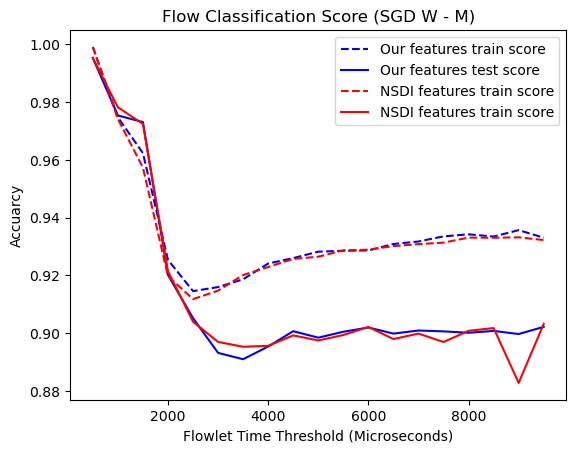

In [5]:
plt.xlabel("Flowlet Time Threshold (Microseconds)")
plt.ylabel("Accuarcy")
plt.title("Flow Classification Score (SGD W - M)")
plt.plot(times, full_train_acc, 'b--', label='Our features train score')
plt.plot(times, full_test_acc, 'b-', label='Our features test score')
plt.plot(times, nsdi_train_acc, 'r--', label='NSDI features train score')
plt.plot(times, nsdi_test_acc, 'r-', label='NSDI features train score')
plt.legend(loc='best')

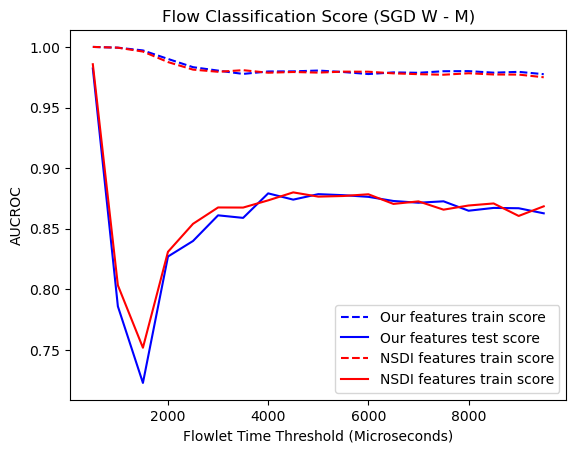

In [6]:
plt.xlabel("Flowlet Time Threshold (Microseconds)")
plt.ylabel("AUCROC")
plt.title("Flow Classification Score (SGD W - M)")
plt.plot(times, full_train_roc, 'b--', label='Our features train score')
plt.plot(times, full_test_roc, 'b-', label='Our features test score')
plt.plot(times, nsdi_train_roc, 'r--', label='NSDI features train score')
plt.plot(times, nsdi_test_roc, 'r-', label='NSDI features train score')
plt.legend(loc='best')

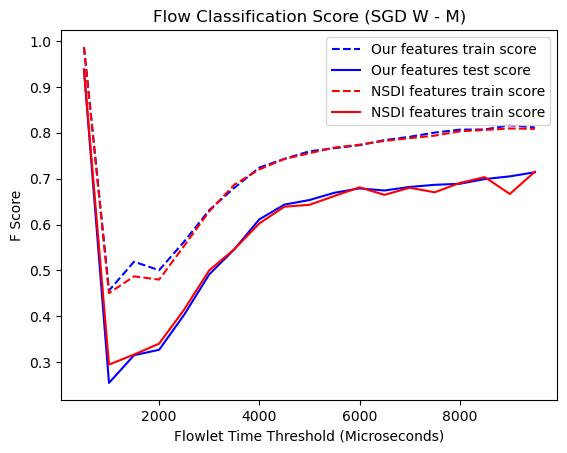

In [7]:
plt.xlabel("Flowlet Time Threshold (Microseconds)")
plt.ylabel("F Score")
plt.title("Flow Classification Score (SGD W - M)")
plt.plot(times, full_train_f, 'b--', label='Our features train score')
plt.plot(times, full_test_f, 'b-', label='Our features test score')
plt.plot(times, nsdi_train_f, 'r--', label='NSDI features train score')
plt.plot(times, nsdi_test_f, 'r-', label='NSDI features train score')
plt.legend(loc='best')

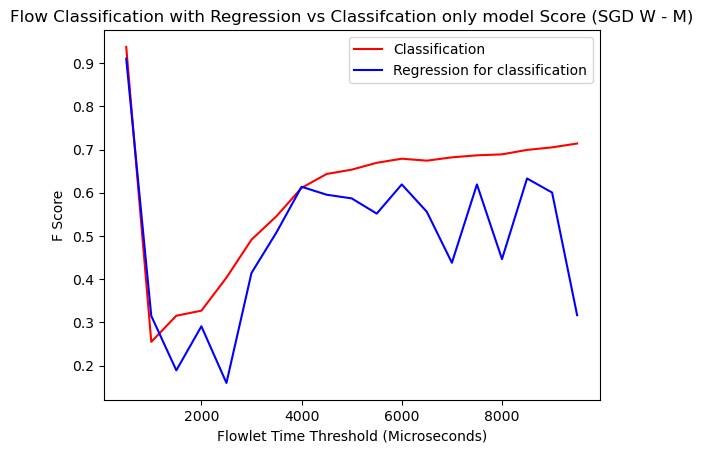

In [8]:
plt.xlabel("Flowlet Time Threshold (Microseconds)")
plt.ylabel("F Score")
plt.title("Flow Classification with Regression vs Classifcation only model Score (SGD W - M)")
plt.plot(times, full_test_f, 'r-', label='Classification')
plt.plot(times, full_test_reg_for_class_f1, 'b-', label='Regression for classification')
plt.legend(loc='best')

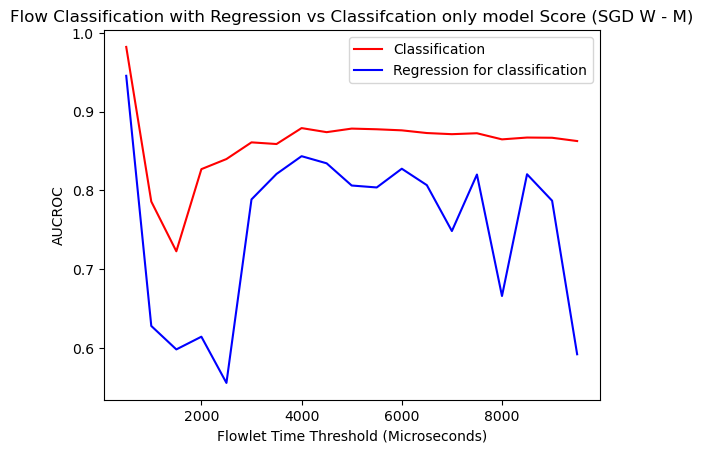

In [9]:
plt.xlabel("Flowlet Time Threshold (Microseconds)")
plt.ylabel("AUCROC")
plt.title("Flow Classification with Regression vs Classifcation only model Score (SGD W - M)")
plt.plot(times, full_test_roc, 'r-', label='Classification')
plt.plot(times, full_test_reg_for_class_roc, 'b-', label='Regression for classification')
plt.legend(loc='best')

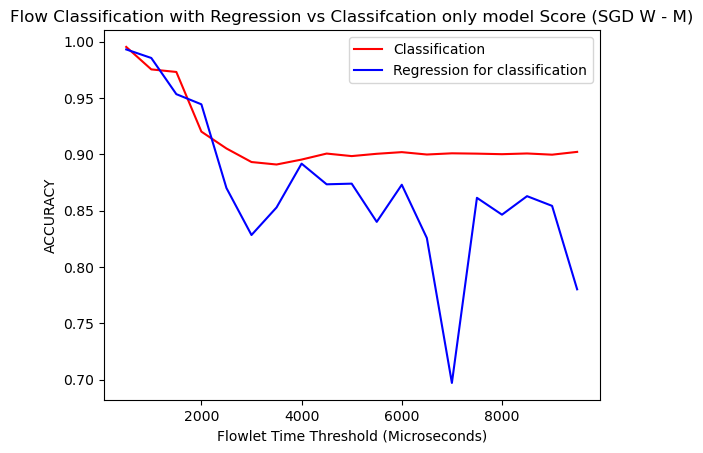

In [10]:
plt.xlabel("Flowlet Time Threshold (Microseconds)")
plt.ylabel("ACCURACY")
plt.title("Flow Classification with Regression vs Classifcation only model Score (SGD W - M)")
plt.plot(times, full_test_acc, 'r-', label='Classification')
plt.plot(times, full_test_reg_for_class_acc, 'b-', label='Regression for classification')
plt.legend(loc='best')

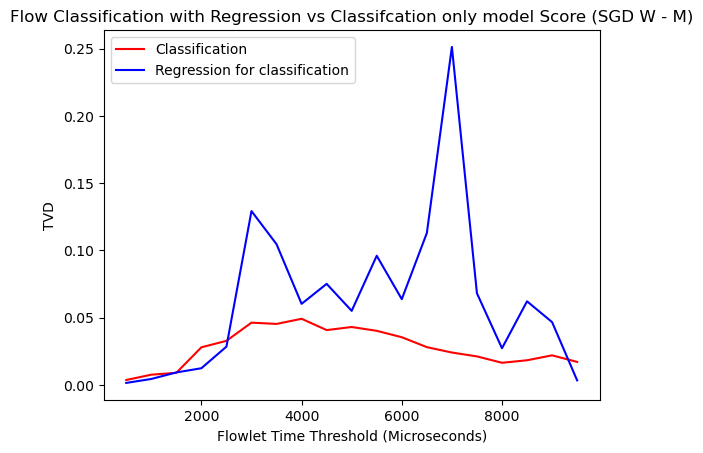

In [11]:
plt.xlabel("Flowlet Time Threshold (Microseconds)")
plt.ylabel("TVD")
plt.title("Flow Classification with Regression vs Classifcation only model Score (SGD W - M)")
plt.plot(times, full_test_tvd, 'r-', label='Classification')
plt.plot(times, full_test_reg_for_class_tvd, 'b-', label='Regression for classification')
plt.legend(loc='best')

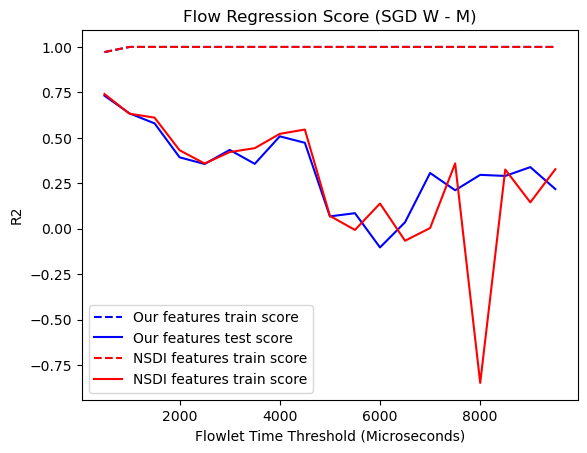

In [12]:
plt.xlabel("Flowlet Time Threshold (Microseconds)")
plt.ylabel("R2")
plt.title("Flow Regression Score (SGD W - M)")
plt.plot(times, full_train_r2, 'b--', label='Our features train score')
plt.plot(times, full_test_r2, 'b-', label='Our features test score')
plt.plot(times, nsdi_train_r2, 'r--', label='NSDI features train score')
plt.plot(times, nsdi_test_r2, 'r-', label='NSDI features train score')
plt.legend(loc='best')

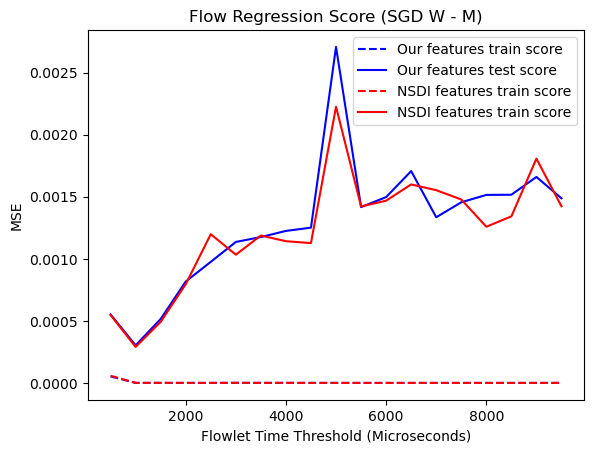

In [60]:
plt.xlabel("Flowlet Time Threshold (Microseconds)")
plt.ylabel("MSE")
plt.title("Flow Regression Score (SGD W - M)")
plt.plot(times, full_train_mse, 'b--', label='Our features train score')
plt.plot(times, full_test_mse, 'b-', label='Our features test score')
plt.plot(times, nsdi_train_mse, 'r--', label='NSDI features train score')
plt.plot(times, nsdi_test_mse, 'r-', label='NSDI features train score')
plt.legend(loc='best')

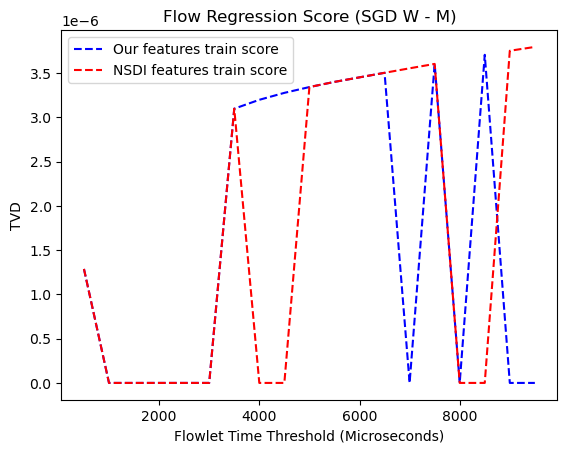

In [31]:
plt.xlabel("Flowlet Time Threshold (Microseconds)")
plt.ylabel("TVD")
plt.title("Flow Regression Score (SGD W - M)")
plt.plot(times, full_train_reg_tvd, 'b--', label='Our features train score')
plt.plot(times, nsdi_train_reg_tvd, 'r--', label='NSDI features train score')
plt.legend(loc='best')

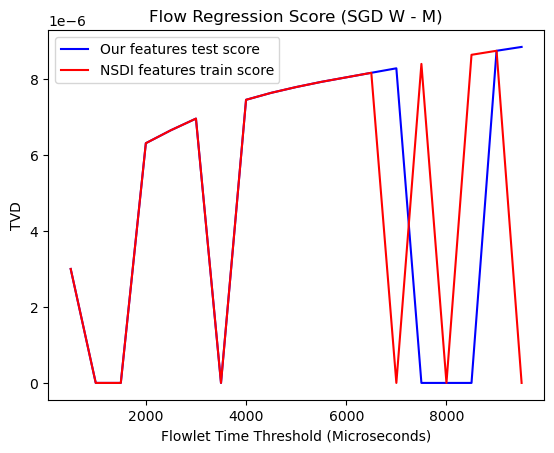

In [32]:
plt.xlabel("Flowlet Time Threshold (Microseconds)")
plt.ylabel("TVD")
plt.title("Flow Regression Score (SGD W - M)")
plt.plot(times, full_test_reg_tvd, 'b-', label='Our features test score')
plt.plot(times, nsdi_test_reg_tvd, 'r-', label='NSDI features train score')
plt.legend(loc='best')

# Count number of e/m flows

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [24]:
dtype = {'size': 'Int'}
df = pd.read_csv("flows.csv", on_bad_lines='skip')
names = df.columns
df[names] = df[names].apply(pd.to_numeric, errors='coerce')
df['size_class'] = (df['size'] > 67000)

In [26]:
(np.sum(df['size_class'].values) / len(df['size_class'].values)) * 100

0.004703392321712034

In [27]:
tf = 15.047552807052028 # %
sp = 0.004703392321712034 # %